# Predviđanje Alzheimerove bolesti u ranim fazama korištenjem modela strojnog učenja

## 1. Uvod
Projekt se kroz prvu i drugu fazu bavi replikacijom rezultata [znanstvenog članka](https://www.frontiersin.org/articles/10.3389/fpubh.2022.853294/full).

Korišteni skup podataka nalazi se [ovdje](https://www.kaggle.com/datasets/jboysen/mri-and-alzheimers).

### Problematika

Alzheimerova bolest je neurodegenerativna bolest koja obično počinje polako i postupno se pogoršava. Ona je uzrok 60-70% slučajeva demencije. Najčešći rani simptom je teškoća u pamćenju nedavnih događaja. Kako bolest napreduje, simptomi mogu uključivati probleme s govorom, dezorijentaciju, promjene raspoloženja, gubitak motivacije i probleme s ponašanjem.

### Opis značajki

* Group - dijagnoza
* ID - Identifikacijski broj
* M/F - Spol (M = muško, F = žensko)
* Hand - Dominantna ruka
* Age - Dob u godinama
* EDUC - Broj godina obrazovanja
* SES - Socijalno-ekonomski status
* MMSE - Mini Mental State Examination (test za procjenu kognitivnih funkcija)
* CDR - Clinical Dementia Rating (klinička ocjena demencije)
* eTIV - Procijenjeni ukupni intrakranijalni volumen
* nWBV - Normalizirani volumen cijelog mozga
* ASF - Faktor skaliranja atlasa
* Delay - Kašnjenje

## 2. Učitavanje i analiza podatkovnog skupa

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('Dataset.csv')
df.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [2]:
df_without_duplicate_subject_id = df.drop_duplicates(subset='Subject ID')
df_2 = df_without_duplicate_subject_id

unique_hand = df_2['Hand'].unique()

df.shape, df_2.shape[0], unique_hand, df['Age'].min(), df['Age'].max()

((373, 15), 150, array(['R'], dtype=object), 60, 98)

Podatkovni skup ima 373 retka i 15 stupaca. Sastoji se od MRI podataka za 150 različitih ispitanika u dobi od 60 do 96 godina.
Svi ispitanici su dešnjaci.

### Tipovi podataka

Tipovi podataka koji se koriste su: **int64**, **object** i **float64**.

Stupci **Subject ID**, **MRI ID**, **M/F** i **Hand** su tipa object, a ostali stupci su cijeli ili realni brojevi.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


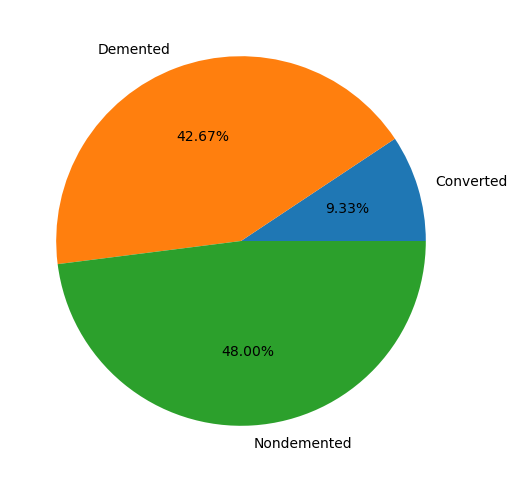

In [4]:
group = df_2.groupby('Group').count().loc[:, 'Subject ID'].values
group_name = df_2.groupby('Group').count().index.values
plt.figure(figsize=(6, 6))
plt.pie(group, labels=group_name, autopct='%1.2f%%')
plt.show()

Stupac **Group** čine tri klase: Demented, Nondemented i Converted.

64 ispitanika je klasificirano u klasu Demented prilikom prvog posjeta i u toj klasi su ostali tijekom cijelog istraživanja. 72 ispitanika su nedementna (klasa Nondemented). 14 ispitanika je inicijalno u klasi Nondemented, ali su kasnije prebačeni u klasu Demented. Ti ispitanici pripadaju grupi Converted.

In [5]:
df = df.loc[df['Visit']==1]
df = df.drop(['Hand', 'MRI ID', 'Visit'], axis=1)

### Nedostajuće vrijednosti

Identificirano je da stupci **SES** i **MMSE** sadrže nedostajuće vrijednosti. Nad tim vrijednostima izvršena je imputacija pomoću medijana grupiranog po vrijednostima stupca **EDUC**.

In [6]:
df.isna().any()

Subject ID    False
Group         False
MR Delay      False
M/F           False
Age           False
EDUC          False
SES            True
MMSE          False
CDR           False
eTIV          False
nWBV          False
ASF           False
dtype: bool

In [7]:
for i in ['SES', 'MMSE']:
    df[i].fillna(df.groupby('EDUC')[i].transform('median'), inplace=True)

In [8]:
df.describe()

,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,150.0,150.000000,150.000000,150.000000,150.00000,150.000000,150.000000,150.000000,150.000000
mean,0.0,75.446667,14.533333,2.513333,27.56000,0.260000,1474.426667,0.736073,1.206333
std,0.0,7.545421,2.874714,1.103604,2.96847,0.326256,174.683889,0.036458,0.137864
min,0.0,60.000000,6.000000,1.000000,17.00000,0.000000,1123.000000,0.660000,0.883000
25%,0.0,70.000000,12.000000,2.000000,26.00000,0.000000,1347.250000,0.710000,1.121000
50%,0.0,75.000000,14.000000,2.000000,29.00000,0.000000,1453.500000,0.735000,1.207500
75%,0.0,80.000000,16.000000,3.000000,30.00000,0.500000,1565.250000,0.757750,1.302750
max,0.0,96.000000,23.000000,5.000000,30.00000,1.000000,1987.000000,0.837000,1.563000


### Vizualizacija i analiza podataka

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(15.3, 30.0)

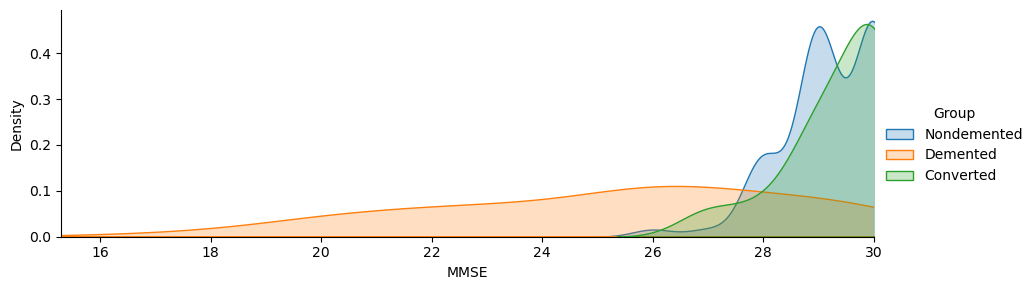

In [9]:
facet = sns.FacetGrid(df, hue="Group", aspect=3)
facet.map(sns.kdeplot,'MMSE', fill=True)
facet.set(xlim=(0, df['MMSE'].max()))
facet.add_legend()
plt.xlim(15.30)

Redefinirajmo kategoričku varijablu **Group** tako što ćemo vrijednosti prikazati pomoću 0 i 1 tako da 0 predstavlja klasu **Nondemented**, a 1 klasu **Demented**.

In [10]:
df['Group'] = df['Group'].replace(['Converted'], ['Demented'])
df['Group'] = df['Group'].replace(['Demented', 'Nondemented'], [1,0])
df.head()

,Subject ID,Group,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,0,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
2,OAS2_0002,1,0,M,75,12,3.0,23.0,0.5,1678,0.736,1.046
5,OAS2_0004,0,0,F,88,18,3.0,28.0,0.0,1215,0.710,1.444
7,OAS2_0005,0,0,M,80,12,4.0,28.0,0.0,1689,0.712,1.039
10,OAS2_0007,1,0,M,71,16,2.0,28.0,0.5,1357,0.748,1.293


C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.6, 0.9)

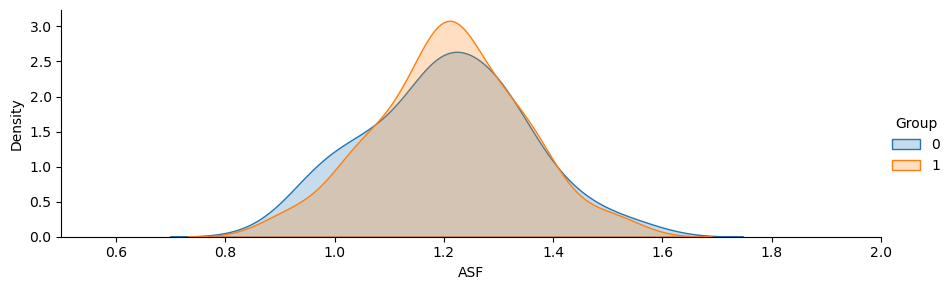

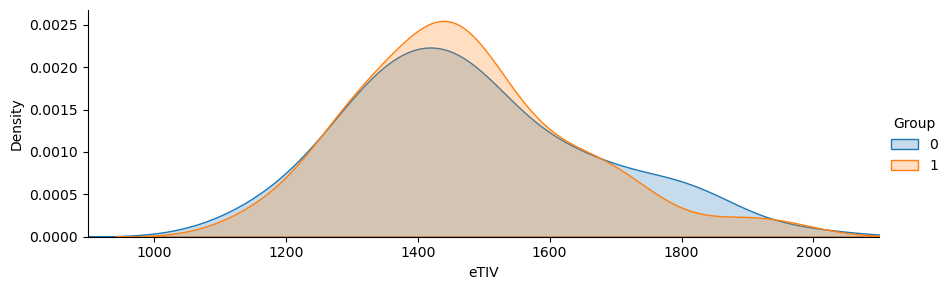

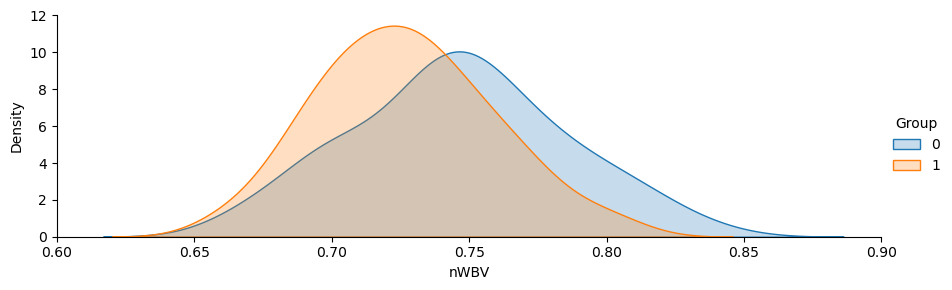

In [11]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'ASF',fill= True)
facet.set(xlim=(0, df['ASF'].max()))
facet.add_legend()
plt.xlim(0.5, 2)

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'eTIV',fill= True)
facet.set(xlim=(0, df['eTIV'].max()))
facet.add_legend()
plt.xlim(900, 2100)

facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'nWBV',fill= True)
facet.set(xlim=(0, df['nWBV'].max()))
facet.add_legend()
plt.xlim(0.6,0.9)

Volumen mozga u grupi bez demencije veći je nego u grupi s demencijom.

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(0.0, 0.16)

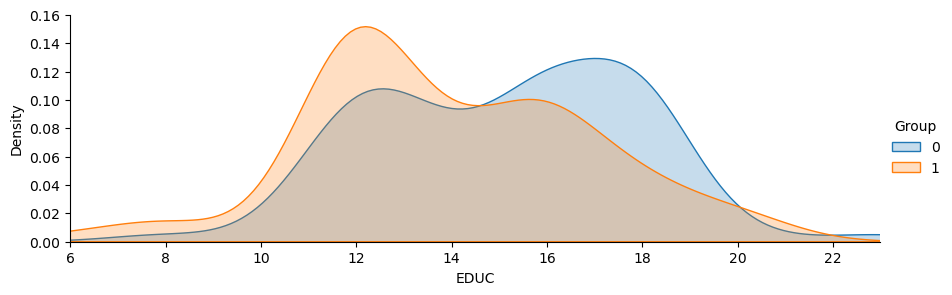

In [12]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'EDUC',fill= True)
facet.set(xlim=(df['EDUC'].min(), df['EDUC'].max()))
facet.add_legend()
plt.ylim(0, 0.16)

Što se tiče broja godina obrazovanja, pacijenti s demencijom su manje obrazovani.

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


(50.0, 100.0)

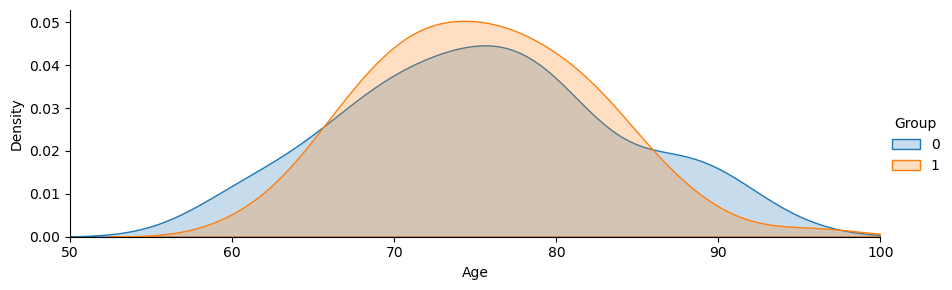

In [13]:
facet= sns.FacetGrid(df,hue="Group", aspect=3)
facet.map(sns.kdeplot,'Age',fill= True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(50,100)

Među pacijentima s demencijom ima veći udio osoba u dobi od 70-80 godina nego među pacijentima bez demencije.

Redefinirajmo kategoričku varijablu **M/F** tako što ćemo vrijednosti prikazati pomoću 0 i 1 tako da vrijedi **M = 1** i **F = 0**.

In [14]:
df['M/F'] = df['M/F'].replace(['M','F'], [1,0])
df_2 = df.drop_duplicates(subset='Subject ID')

In [29]:
def bar_chart(feature):
    demented = df_2[df_2['Group']==1][feature].value_counts()
    nondemented = df_2[df_2['Group']==0][feature].value_counts()
    df_bar = pd.DataFrame([demented, nondemented])
    df_bar.index = ['Demented','Nondemented']
    df_bar.plot(kind='bar',stacked=True, figsize=(6, 4))

Text(0.5, 1.0, 'Gender and Demented rate')

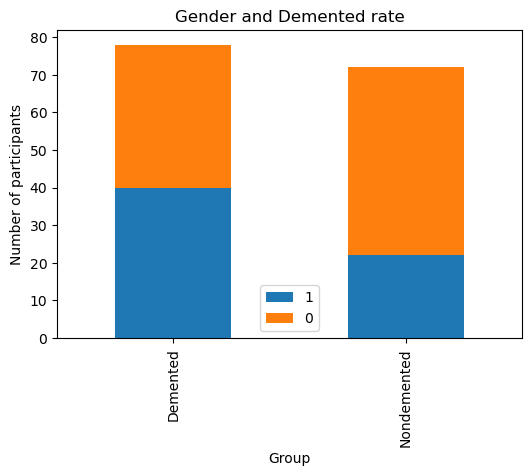

In [30]:
bar_chart('M/F')
plt.xlabel('Group')
plt.ylabel('Number of participants')
plt.legend()
plt.title('Gender and Demented rate')

Vjerojatnije je da će muškarci imati demenciju ili Alzheimerovu bolest nego žene.

#### Histogram značajki

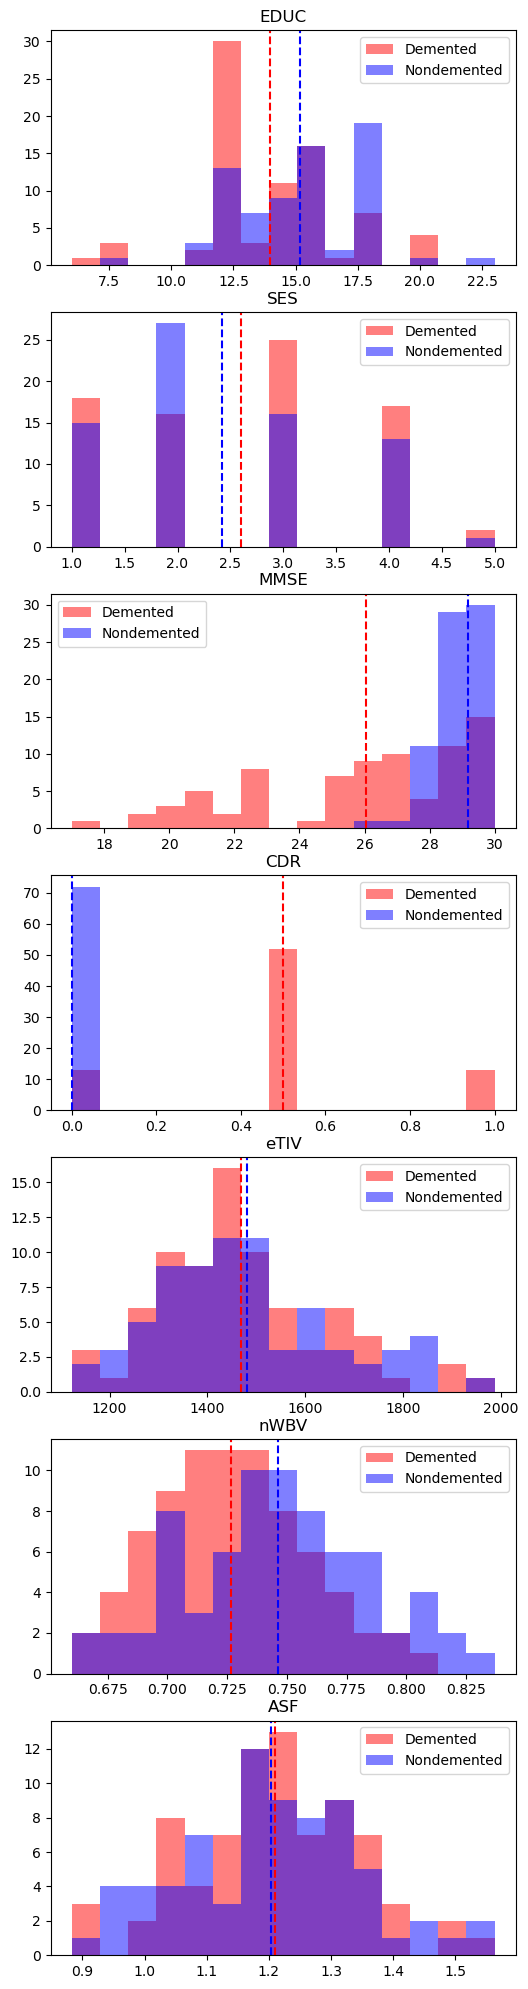

In [22]:
def plot_feature_by_group(ax, feature_name):
    feature_min = df[feature_name].min()
    feature_max = df[feature_name].max()
    ax.hist(df.loc[df['Group']==1, feature_name], bins=15, alpha=0.5, color='r', label='Demented', range=(feature_min, feature_max))
    ax.hist(df.loc[df['Group']==0, feature_name], bins=15, alpha=0.5, color='b', label='Nondemented', range=(feature_min, feature_max))
    ax.axvline(df.loc[df['Group']==1, feature_name].mean(), color='r', linestyle='dashed')
    ax.axvline(df.loc[df['Group']==0, feature_name].mean(), color='b', linestyle='dashed')
    ax.set_title(feature_name)
    ax.legend(loc='best')

fig, ax = plt.subplots(7, 1, figsize=(6, 25))
for i, column_name in enumerate(df.columns[5:]):
    plot_feature_by_group(ax[i], column_name)

Slika prikazuje distribuciju značajki u ovisnosti o značajki Group. Vertikalnim isprekidanim crtama označene su srednje vrijednosti podataka.

Dobru separaciju po grupama imaju značajke MMSE i CDR.

#### Boxplot značajki

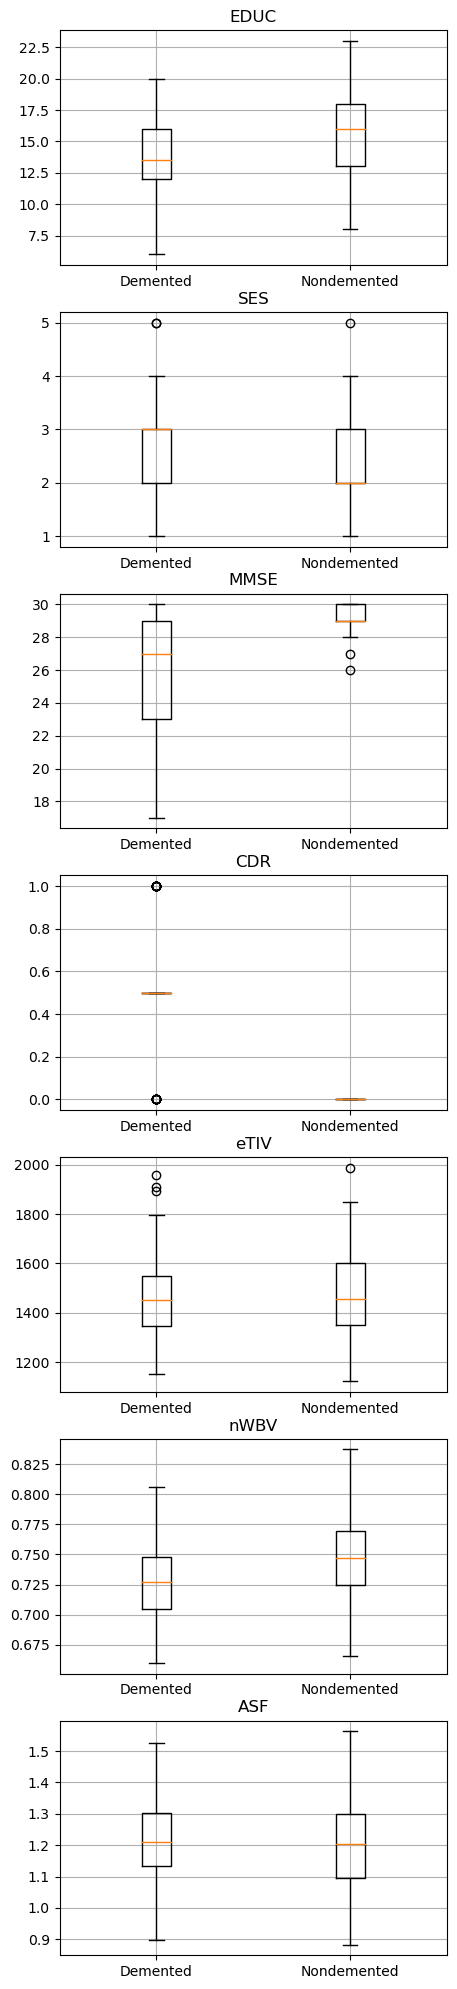

In [20]:
def boxplot_feature_by_group(ax, feature_name):
    boxplot_data = [df.loc[df['Group']==1, feature_name], df.loc[df['Group']==0, feature_name]]
    ax.boxplot(boxplot_data)
    ax.set_xticks([1, 2], ['Demented', 'Nondemented'])
    ax.set_title(feature_name)
    ax.grid()

fig, ax = plt.subplots(7, 1, figsize=(5, 25))
for i, column_name in enumerate(df.columns[5:]):
    boxplot_feature_by_group(ax[i], column_name)

Stršeće vrijednosti izražene kod značajke MMSE.

#### Korelacijska matrica

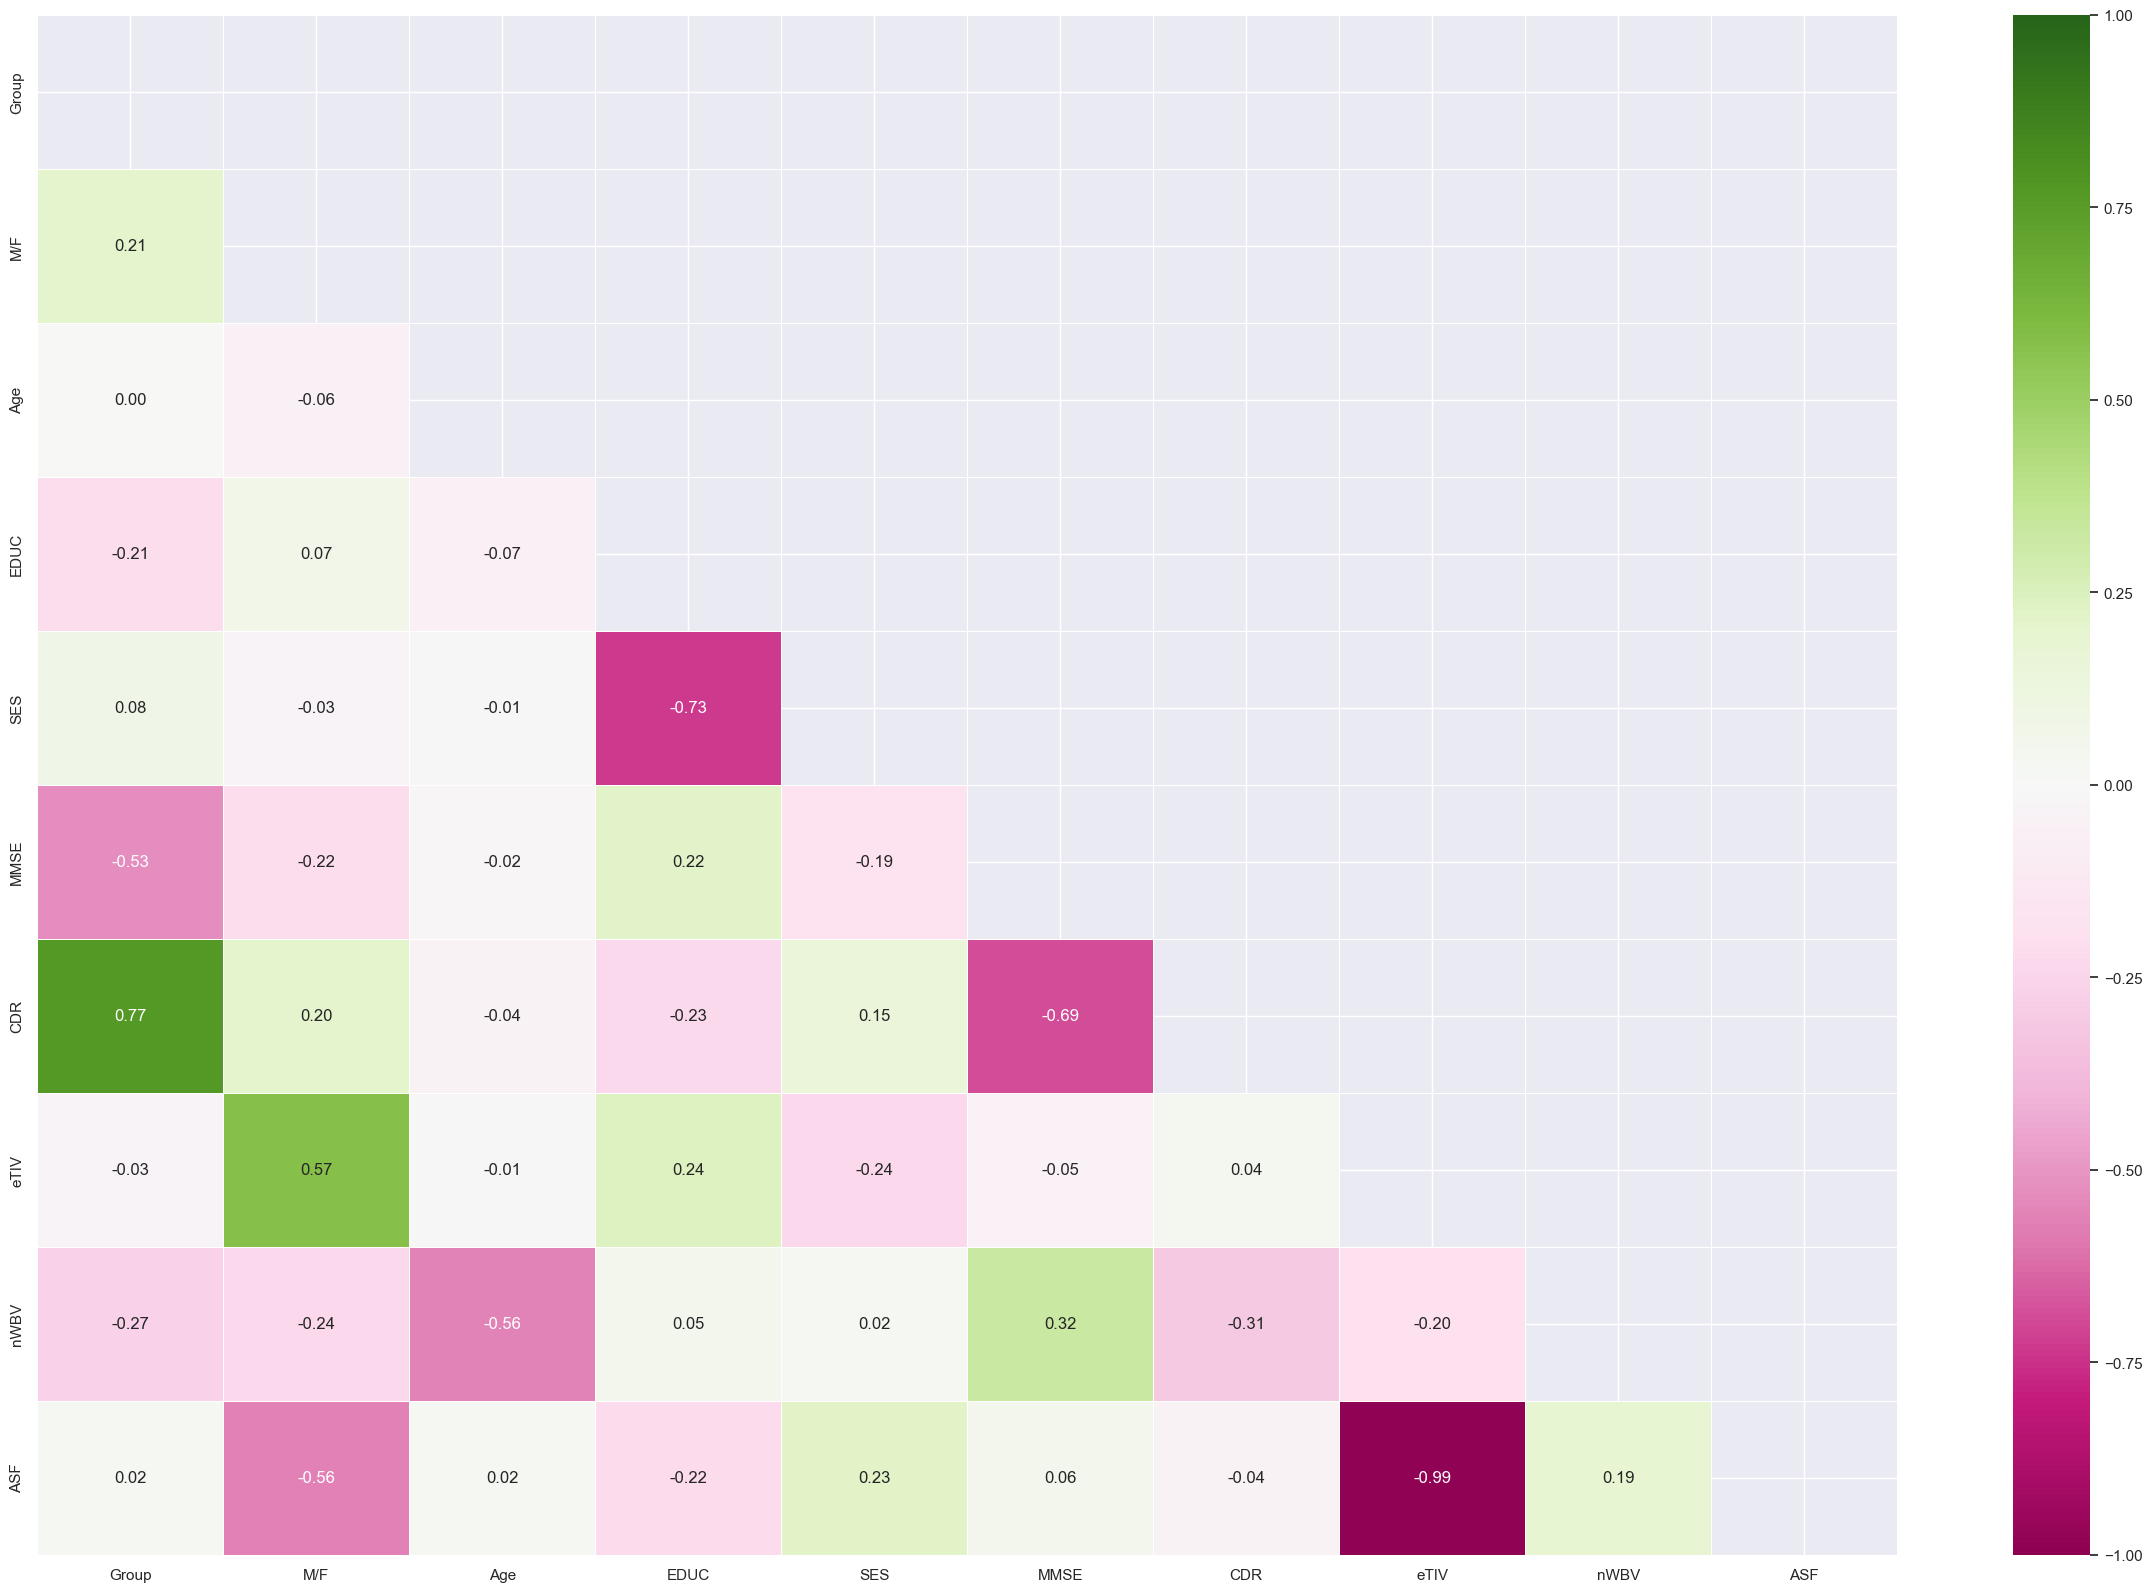

In [19]:
df_corr = df.drop(['Subject ID', 'MR Delay'], axis=1)
sns.set(rc={'figure.figsize':(30,20)})
mask = np.triu(np.ones((10,10)))
sns.heatmap(df_corr.corr(), mask=mask, annot=True, fmt=".2f", cmap="PiYG", linewidths=.5, vmin=-1.0, vmax=1.0)
plt.show()

Slika prikazuje korelacijsku matricu za sve parove značajki.
Vidljiva je korelacija između dvije značajke u svakom polju matrice. Iznos korelacije opisan je intenzitetom boje i brojem od -1 do 1. Pozitivna korelacija znači da povećanje jedne značajke će dovesti do povećanja druge (i obrnuto).

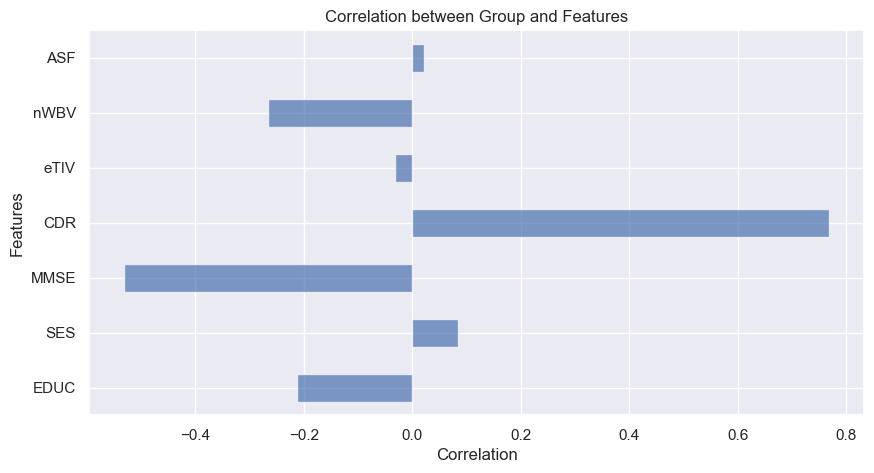

In [20]:
correlations = df.iloc[:, 5:].corrwith(df['Group']).transpose()

plt.figure(figsize=(10, 5))
correlations.plot(kind='barh', color='b', alpha=0.7)
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.title('Correlation between Group and Features')
plt.show()

Prikazana je korelacija značajki u odnosu na grupu kojoj ispitanik pripada.

CDR i MMSE imaju najveću apsolutnu vrijednost korelacije. Povećanje vrijednosti CDR dovodi do veće vjerojatnosti da je osoba dementna, a povećanje vrijednosti MMSE dovodi do suprotnog ishoda.

Age je značajka s najmanjom korelacijom i time se pokazuje da nema velik utjecaj na ciljnu značajku Group. Uklanjanjem te značajke iz skupa dobio bi se jednostavniji i točniji model.

#### Matrica dijagrama raspršenja

C:\Users\least\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


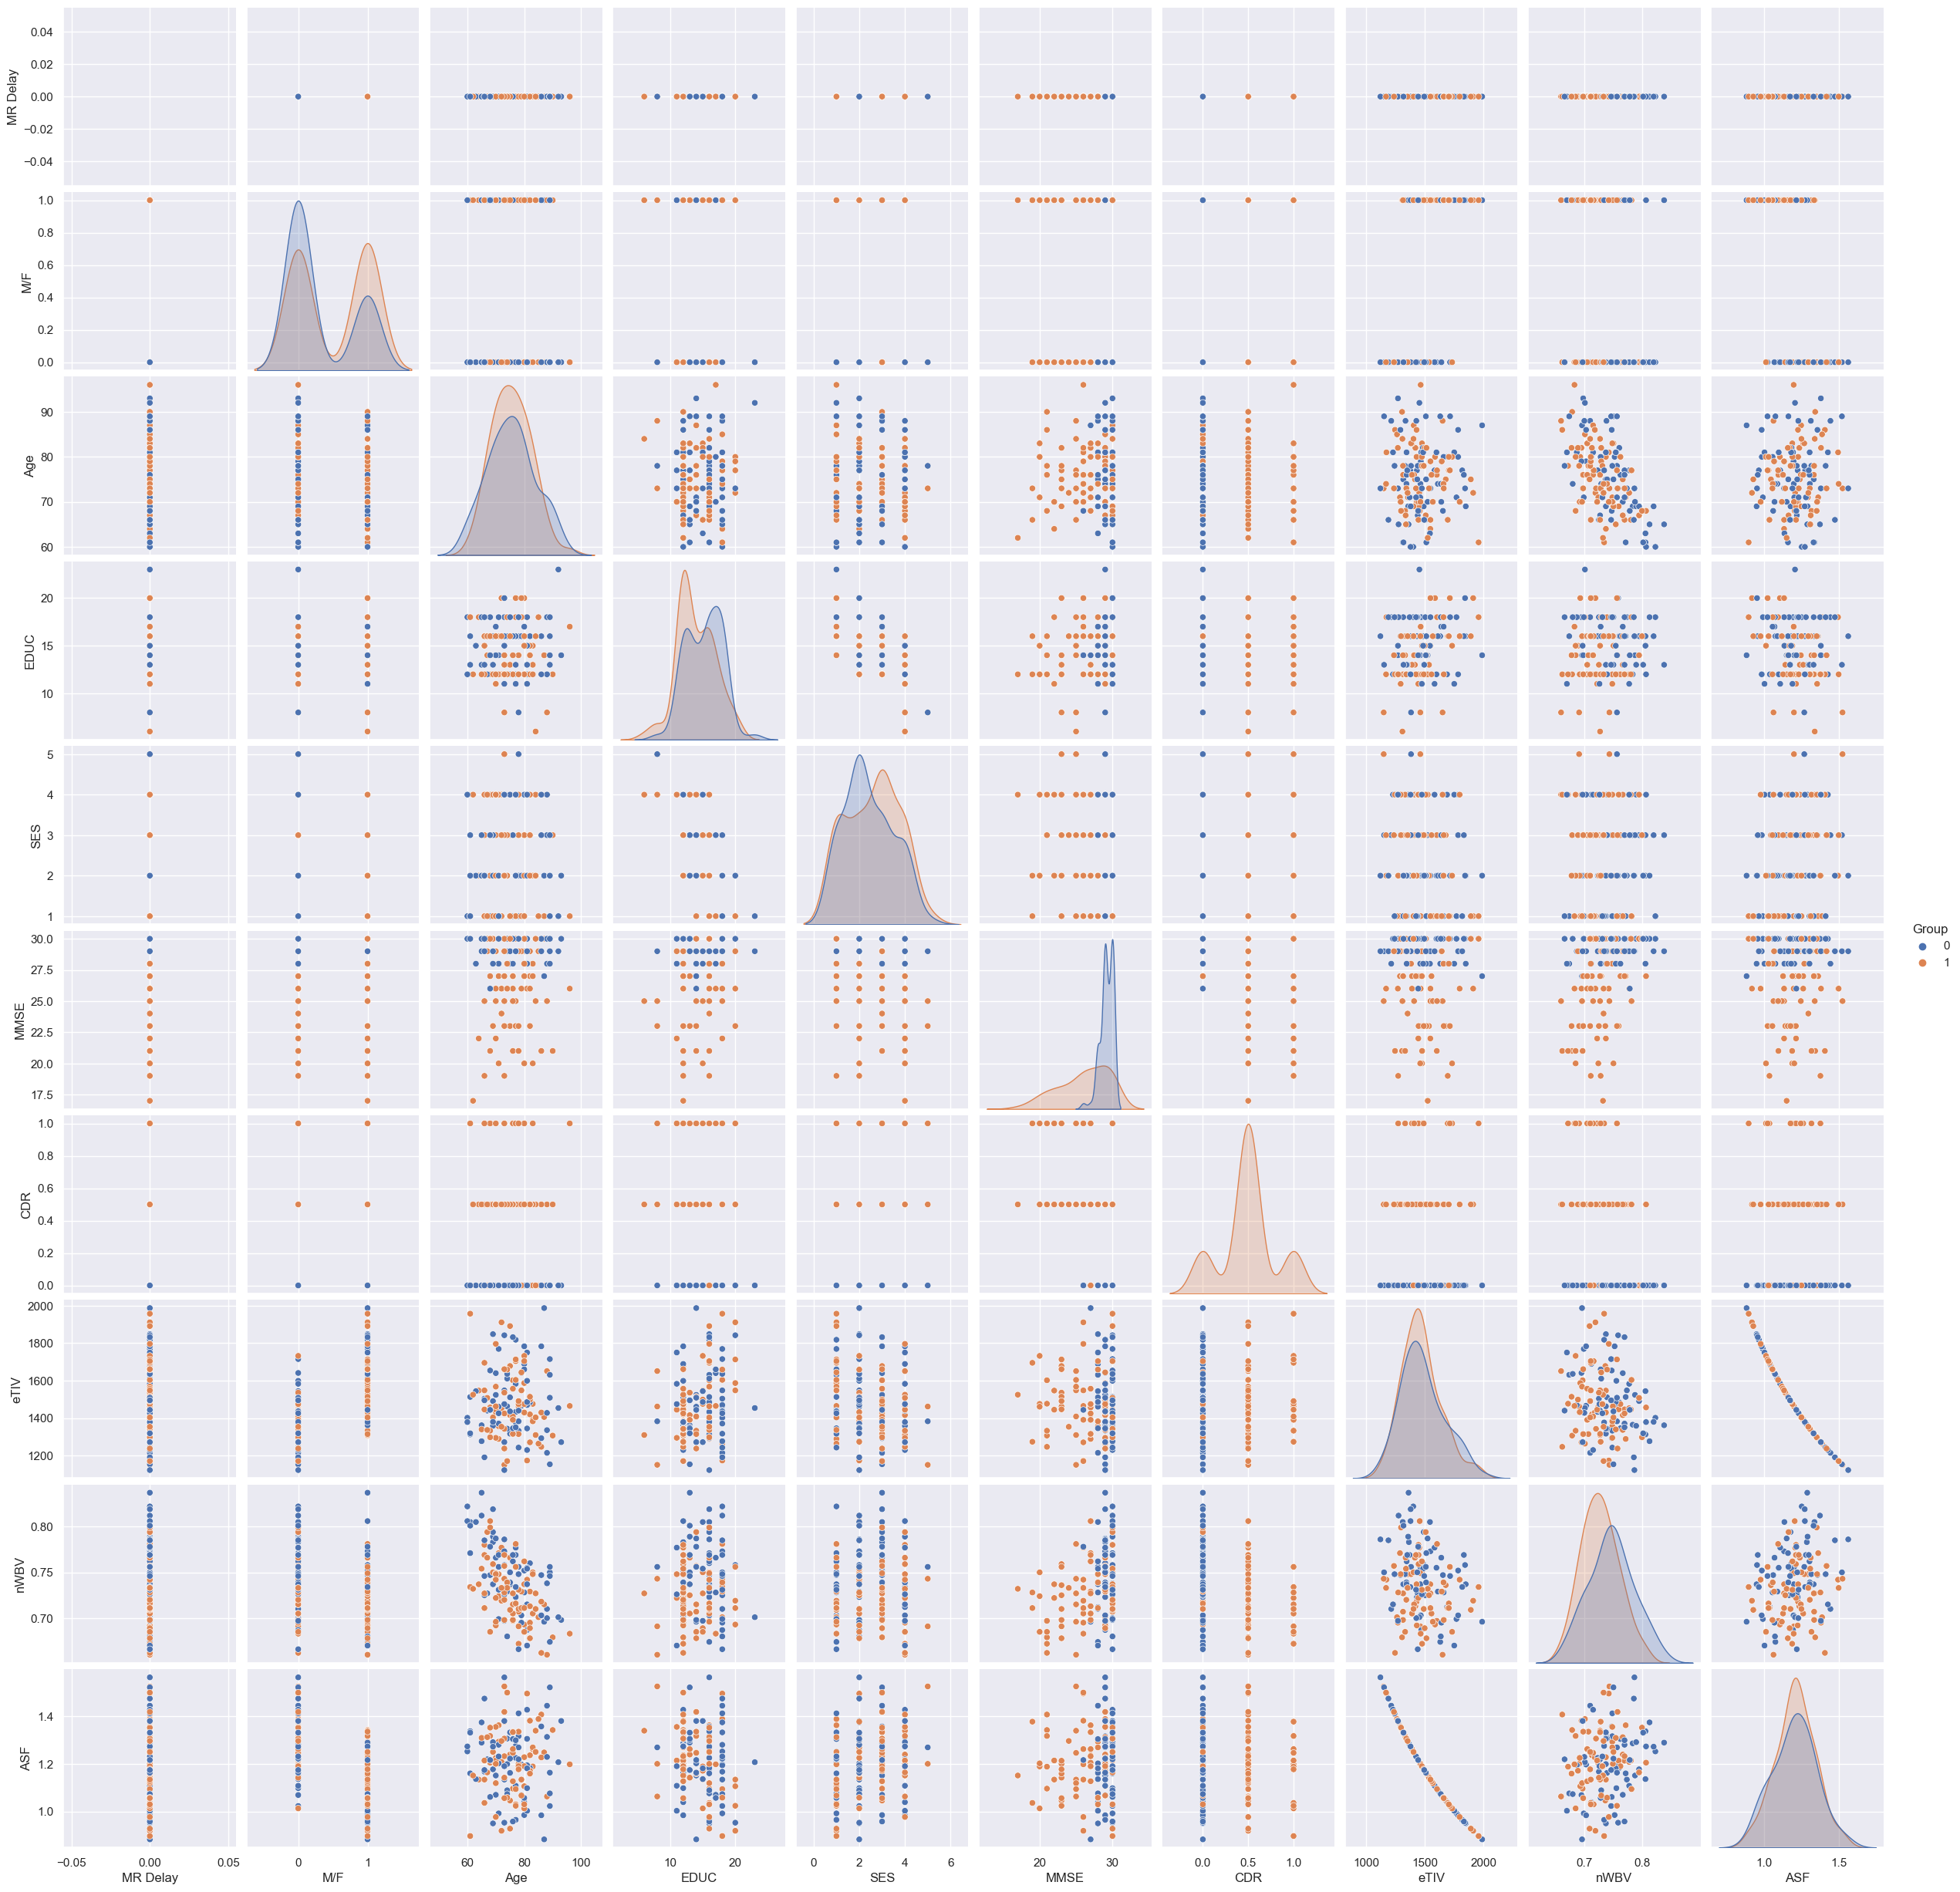

In [21]:
sns.pairplot(df.iloc[:,1:], hue="Group")
plt.show()

Najveća negativna korelacija je između značajki ASF i eTIV.

### Priprema i podjela podataka

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

df = df.copy()
df = df[['Group', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'CDR']]
df['Group'] = pd.Categorical(df['Group'])

X = df[['M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF', 'CDR']]
y = df['Group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

Po uzoru na članak, kao oznaka je uzeta značajka **Group** i proučavaju se podaci koji se odnose samo na prvi posjet ispitanika. U idućoj fazi projekta, značajka **Group** bi se mogla ukloniti iz skupa podataka te se kao oznaka može koristiti značajka **CDR**.

U članku nije navedeno skaliraju li se značajke.

### Klasifikacijski modeli

In [23]:
metrics_list = []

def calculate_metrics(classifier, name, param_grid=None, hard=False):
    global metrics_list
    
    if param_grid is not None:
        grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        classifier = grid_search.best_estimator_
    else:
        classifier.fit(X_train, y_train)
    
    y_pred = classifier.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    print(f"Accuracy: {accuracy}%")
    
    precision = round(precision_score(y_test, y_pred, average='weighted'), 2)
    print("Precision:", precision)

    recall = round(recall_score(y_test, y_pred, average='weighted'), 2)
    print("Recall:", recall)

    f1 = round(f1_score(y_test, y_pred, average='weighted'), 2)
    print("F1-score:", f1)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.light_palette("orange", as_cmap=True), cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    if hard is False:
        plt.subplot(1, 2, 2)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        print("AUC/ROC:", round(roc_auc, 2))
        plt.plot(fpr, tpr, color='darkorange', lw=2)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        
    metrics_list.append({
        'Classifier': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

#### Decision Tree (DT)

Accuracy: 86.67%
Precision: 0.89
Recall: 0.87
F1-score: 0.86
AUC/ROC: 0.83


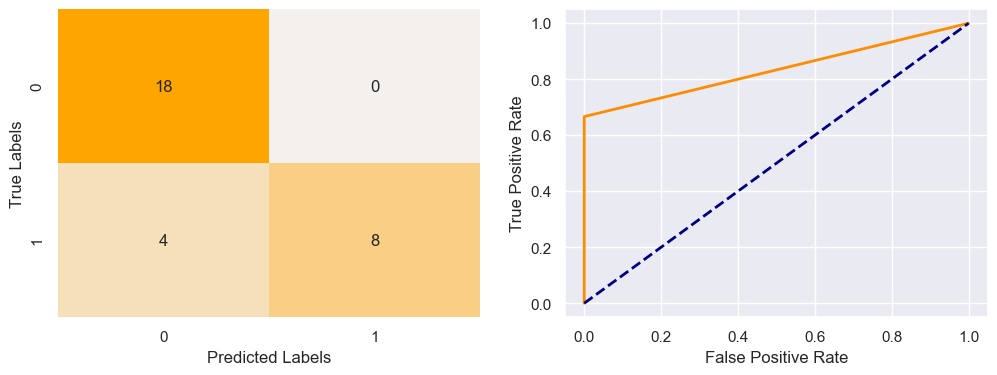

In [24]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve

dt_classifier = DecisionTreeClassifier(random_state=42)
param_grid = { 'max_depth': [1, 5, 10, 100, 1000] }
calculate_metrics(dt_classifier, "Decision Tree", param_grid)

#### Random Forest (RF)

Accuracy: 83.33%
Precision: 0.84
Recall: 0.83
F1-score: 0.83
AUC/ROC: 0.83


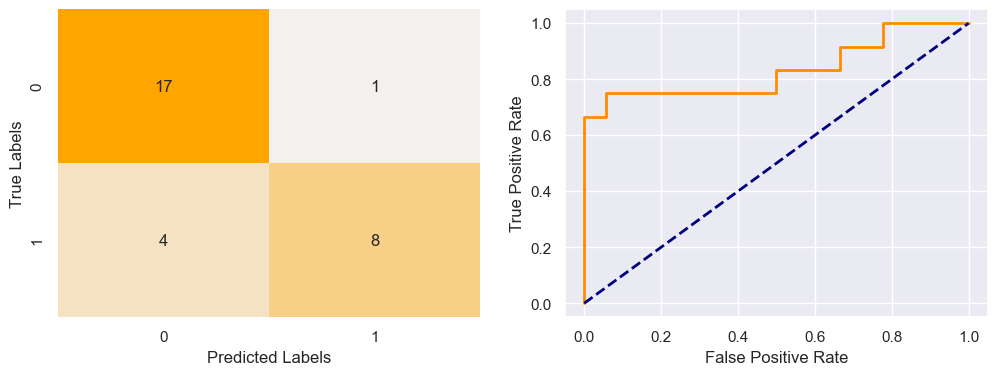

In [25]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
calculate_metrics(rf_classifier, "Random Forest", param_grid)

#### Stroj potpornih vektora (SVM)

Accuracy: 86.67%
Precision: 0.89
Recall: 0.87
F1-score: 0.86
AUC/ROC: 0.82


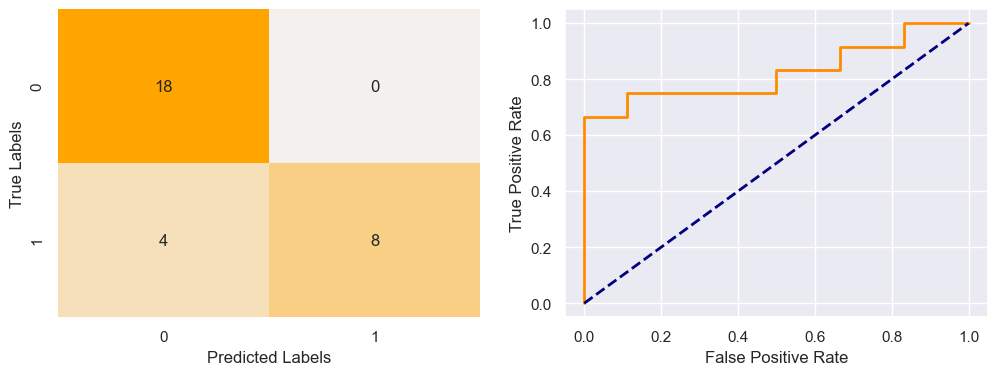

In [26]:
from sklearn.svm import SVC

svm_classifier = SVC(probability=True)
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.01, 0.1]
}
calculate_metrics(svm_classifier, "SVM", param_grid)

#### XGBoost

Accuracy: 86.67%
Precision: 0.89
Recall: 0.87
F1-score: 0.86
AUC/ROC: 0.79


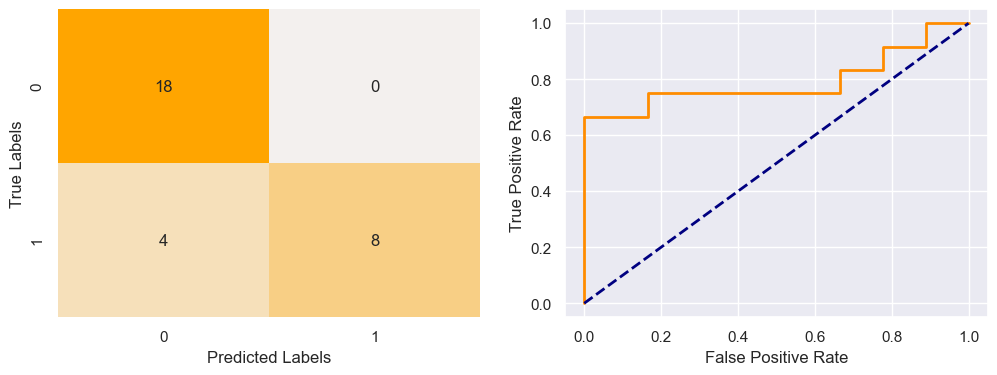

In [27]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}
calculate_metrics(xgb_classifier, "XGBoost", param_grid)

#### Voting

Accuracy: 76.67%
Precision: 0.76
Recall: 0.77
F1-score: 0.76


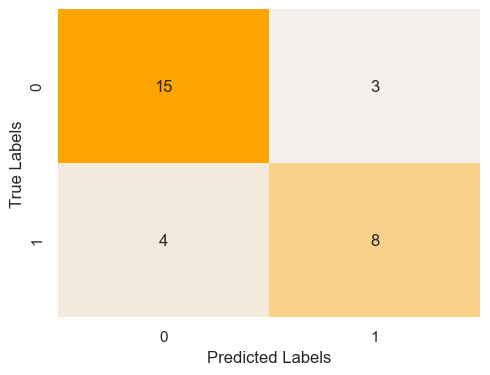

In [28]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('decision tree', dt_classifier),
    ('random_forest', rf_classifier),
    ('svm', svm_classifier),
    ('xgboost', xgb_classifier)
]
hard_voting_classifier = VotingClassifier(estimators=classifiers, voting='hard')
calculate_metrics(hard_voting_classifier, "Hard Voting", hard=True)

Accuracy: 80.0%
Precision: 0.8
Recall: 0.8
F1-score: 0.8
AUC/ROC: 0.74


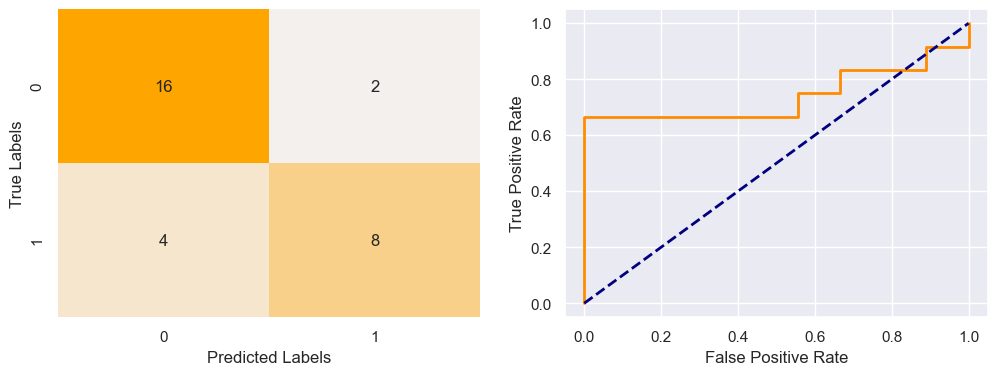

In [29]:
soft_voting_classifier = VotingClassifier(estimators=classifiers, voting='soft')
calculate_metrics(soft_voting_classifier, "Soft Voting")

### Usporedba klasifikacijskih modela

In [30]:
metrics_df = pd.DataFrame(metrics_list)
metrics_df

,Classifier,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,86.67,0.89,0.87,0.86
1,Random Forest,83.33,0.84,0.83,0.83
2,SVM,86.67,0.89,0.87,0.86
3,XGBoost,86.67,0.89,0.87,0.86
4,Hard Voting,76.67,0.76,0.77,0.76
5,Soft Voting,80.00,0.80,0.80,0.80


Na temelju analize prikazane u Tablici, rezultati pokazuju da su najbolje tehnike Decision Tree, SVM i XGBoost. Vrijednost točnosti modela Random Forest također je bliska točnosti modela Decision Tree, SVM i XGBoost.

C:\Users\least\AppData\Local\Temp\ipykernel_13732\566606971.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[row, col].set_xticklabels(metrics_df['Classifier'], rotation=45, ha='right')


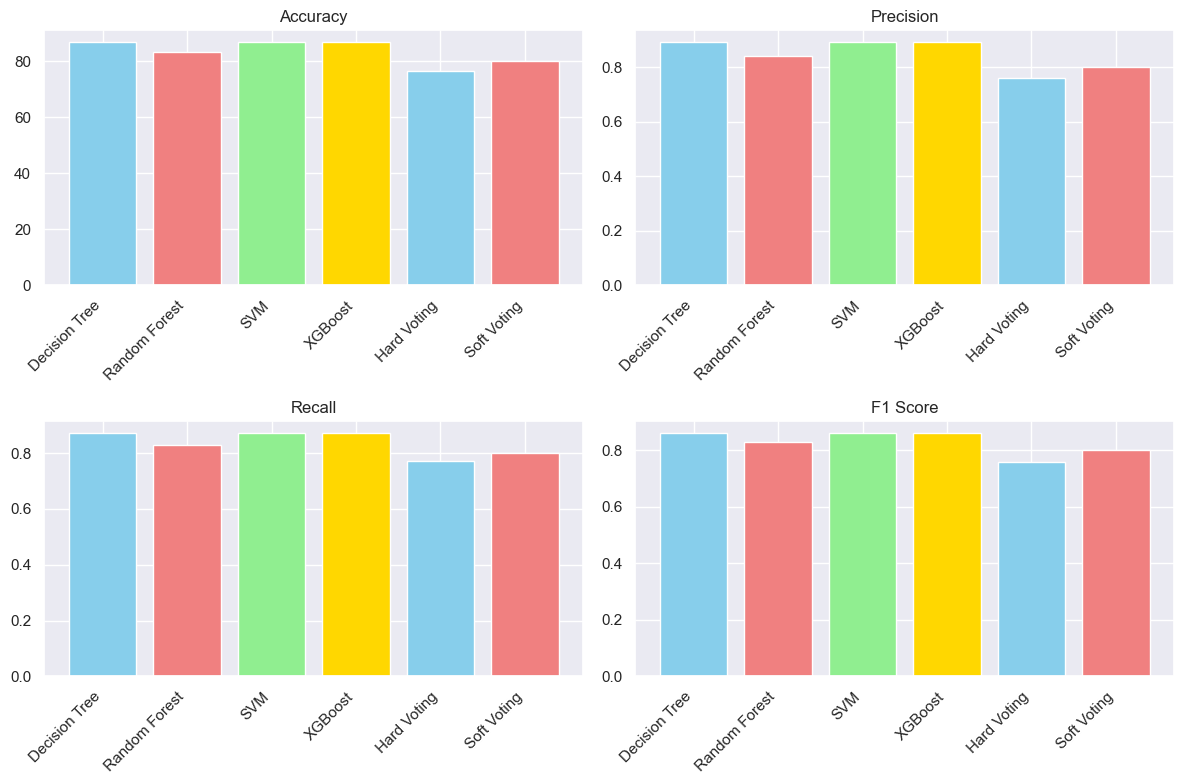

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
for i, metric in enumerate(['Accuracy', 'Precision', 'Recall', 'F1 Score']):
    row, col = divmod(i, 2)
    bars = axes[row, col].bar(metrics_df['Classifier'], metrics_df[metric], color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    axes[row, col].set_title(metric)
    axes[row, col].set_xticklabels(metrics_df['Classifier'], rotation=45, ha='right')
plt.tight_layout()